In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine=engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

Text(0.5, 1.0, 'Hawaii Latest Year Precipitation')

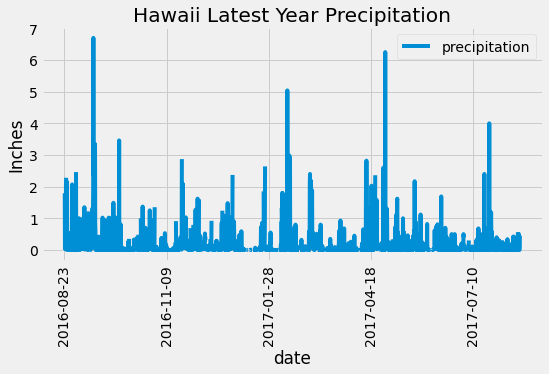

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
first_day_latest_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_latest_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dt.date(2016,8,23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_latest_year)
precip_df = precip_df.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
precip_sorted = precip_df.sort_values("date")
precip_sorted.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_sorted.plot(x="date", y="precipitation", rot=90, figsize=(8,4))
plt.ylabel("Inches")
plt.title("Hawaii Latest Year Precipitation")

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
mean_rain = round(np.mean(precip_sorted["precipitation"]), 2)
print("The mean rain in Hawaii from 2016-08-23 to 2017-08-23 was %.2f inches." % mean_rain)

median_rain = np.nanmedian(precip_sorted["precipitation"])
print("The median rain in Hawaii from 2016-08-23 to 2017-08-23 was %.2f inches." % median_rain)

mode_rain = st.mode(precip_sorted["precipitation"])
print(f"The most frequently occured amount of rain in Hawaii from 2016-08-23 to 2017-08-23 was {mode_rain} inches.")

print(st.normaltest(precip_sorted.dropna()["precipitation"]))
print("The rain data from 2016-08-23 to 2017-08-23 follows a normal distribution.")

var_numpy = np.var(precip_sorted["precipitation"])
print(f"The population variance is {var_numpy}.")

sd_numpy = np.std(precip_sorted["precipitation"])
print(f"The population standard deviation is {sd_numpy}.")

print(f"About 68% of the data is between 0 and {round(mean_rain+sd_numpy,3)} inches.")
print(f"About 95% of the data is between 0 and {round(mean_rain+2*sd_numpy,3)} inches.")
print(f"About 99.7% of the data is between 0 and {round(mean_rain+3*sd_numpy,3)} inches.")

The mean rain in Hawaii from 2016-08-23 to 2017-08-23 was 0.18 inches.
The median rain in Hawaii from 2016-08-23 to 2017-08-23 was 0.02 inches.
The most frequently occured amount of rain in Hawaii from 2016-08-23 to 2017-08-23 was ModeResult(mode=array([0.]), count=array([874])) inches.
NormaltestResult(statistic=2320.213668489221, pvalue=0.0)
The rain data from 2016-08-23 to 2017-08-23 follows a normal distribution.
The population variance is 0.21259051566664816.
The population standard deviation is 0.46107539043701756.
About 68% of the data is between 0 and 0.641 inches.
About 95% of the data is between 0 and 1.102 inches.
About 99.7% of the data is between 0 and 1.563 inches.


## Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(Station).count()
print(f"There are {station_num} stations.")

There are 9 stations.


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).first()[0]

min_rain = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()[0]
min_rain
print("The lowest temperature measured at the station with the most overall measurements was %d°F." % min_rain)

max_rain = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()[0]
print("The highest temperature measured at the station with the most overall measurements was %d°F." % max_rain)

avg_rain = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()[0]
avg_rain
print("The average temperature measured at the station with the most overall measurements was %.2f°F." % avg_rain)

The lowest temperature measured at the station with the most overall measurements was 54°F.
The highest temperature measured at the station with the most overall measurements was 85°F.
The average temperature measured at the station with the most overall measurements was 71.66°F.


Text(0.5, 1.0, 'Temperature Histogram')

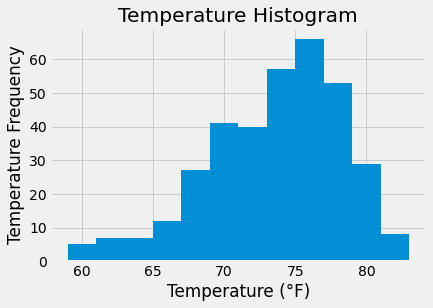

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_latest_year = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= dt.date(2016,8,23)).all()

latest_temps_df = pd.DataFrame(most_active_latest_year)
latest_temps_df

latest_temps_df.hist(bins=12)
plt.xlabel("Temperature (°F)")
plt.ylabel("Temperature Frequency")
plt.title("Temperature Histogram")

# Close session

In [112]:
# Close Session
session.close()